<a href="https://colab.research.google.com/github/fralfaro/MAT281/blob/main/docs/labs/lab_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# MAT281 - Laboratorio N°10

**Objetivo**: Analizar y modelar series temporales de datos delictivos en Montreal, aplicando métodos estadísticos y de aprendizaje automático para la predicción.

> **Nota**: Puede ayudarse de algún asistente virtual como **ChatGPT, Gemini** u otros, así como del autocompletado de **Google Colab**, para avanzar en este laboratorio debido a su extensión.


### Conjunto de datos



<img src="https://svgsilh.com/svg/3350822.svg" width="350"  align="center"/>


El conjunto de datos **`interventionscitoyendo.csv`** proviene del *Service de police de la Ville de Montréal* (SPVM) y contiene el registro de todos los **actos delictivos ocurridos en Montreal entre 2015 y agosto de 2020**.

Cada incidente está clasificado en **categorías generales de delito** e incluye información contextual como la **ubicación geográfica**, la **fecha y hora** del suceso, así como otros atributos relevantes para el análisis.

Este dataset resulta especialmente útil para estudios de **series temporales**, ya que permite agrupar los delitos por intervalos de tiempo (días, semanas, meses) y analizar patrones de comportamiento delictual en la ciudad.

> **Nota**: Puede consultarse más información oficial en el [portal de datos abiertos de Montreal](https://donnees.montreal.ca/ville-de-montreal/actes-criminels).


In [1]:
# librerias

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX


# graficos incrustados
plt.style.use('fivethirtyeight')
%matplotlib inline

# parametros esteticos de seaborn
sns.set_palette("deep", desat=.6)
sns.set_context(rc={"figure.figsize": (12, 4)})

In [28]:
# metrics


def mae(targets, predictions) -> float:
    """
    Calculo de la metrica: mean absolute error (MAE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    return round(np.abs(error).mean(), 4)


def mse(targets, predictions) -> float:
    """
    Calculo de la metrica: mean squared error (MSE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    return round((error ** 2).mean(), 4)


def rmse(targets, predictions) -> float:
    """
    Calculo de la metrica: root mean squared error (RMSE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    return round(np.sqrt((error ** 2).mean()), 4)


# b) Percentage errors

def mape(targets, predictions) -> float:
    """
    Calculo de la metrica: mean absolute percentage error (MAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    # Handle cases where target is zero
    return round(np.abs(error / (targets + 1e-8)).mean(), 4) # Add a small epsilon to avoid division by zero


def maape(targets, predictions) -> float:
    """
    Calculo de la metrica:  mean arctangent percentage error  (MAAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """

    error = predictions - targets
    # Handle cases where target is zero
    return round(np.arctan(np.abs(error / (targets + 1e-8))).mean(), 4) # Add a small epsilon to avoid division by zero


def wmape(targets, predictions) -> float:
    """
    Calculo de la metrica:  weighted mean absolute percentage error (WMAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    sum_values = np.sum(targets)

    if sum_values == 0:
        return np.inf # Keep original behavior if sum of targets is zero
    else:
        return round(np.abs(error).sum() / sum_values,4)


def mmape(targets, predictions) -> float:
    """
    Calculo de la metrica: modified mean absolute percentage error (MMAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = np.abs(predictions - targets)
    denom = 1 + np.abs(targets)

    return round(np.mean(error / denom),4)


def smape(targets, predictions) -> float:
    """
    Calculo de la metrica: symmetric mean absolute percentage error (SMAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    sum_values = np.abs(predictions) + np.abs(targets)

    # Handle cases where sum of absolute values is zero
    return round(2 * np.mean(np.abs(error) / (sum_values + 1e-8)), 4) # Add a small epsilon to avoid division by zero

def summary_metrics(df) -> pd.DataFrame:
    """
    Aplicar las distintas metricas definidas
    :param df:  dataframe con las columnas: ['y','yhat']
    :return: dataframe con las metricas especificadas
    """
    df_result = pd.DataFrame()

    y_true = df['y']
    y_pred = df['yhat']

    df_result['mae'] = [round(mae(y_true, y_pred), 4)]
    df_result['mse'] = [round(mse(y_true, y_pred), 4)]
    df_result['rmse'] = [round(rmse(y_true, y_pred), 4)]

    df_result['mape'] = [round(mape(y_true, y_pred), 4)]
    df_result['maape'] = [round(maape(y_true, y_pred), 4)]
    df_result['wmape'] = [round(wmape(y_true, y_pred), 4)]
    df_result['mmape'] = [round(mmape(y_true, y_pred), 4)]
    df_result['smape'] = [round(smape(y_true, y_pred), 4)]

    # nombre del modelo por defecto
    #try:
    #    model = df['model'][0]
    #    df_result['model'] = [model]
    #except:
    #    df_result['model'] = ['---']

    return df_result

In [3]:
# read data

validate_categorie = [
  'Introduction', 'Méfait','Vol dans / sur véhicule à moteur', 'Vol de véhicule à moteur',
]

df = pd.read_csv("https://raw.githubusercontent.com/fralfaro/MAT281/main/docs/labs/data/interventionscitoyendo.csv", sep=",", encoding='latin-1')
df.columns = df.columns.str.lower()
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

df = df.loc[lambda x: x['categorie'].isin(validate_categorie)]
df = df.sort_values(['categorie','date'])
df.head()

,categorie,date,quart,pdq,x,y,longitude,latitude
3462,Introduction,2015-01-01,jour,42.0,297210.375006,5.050179e+06,-73.597273,45.591480
8370,Introduction,2015-01-01,soir,13.0,297145.531007,5.032845e+06,-73.597834,45.435501
11968,Introduction,2015-01-01,nuit,8.0,289215.072000,5.036423e+06,-73.699308,45.467564
12763,Introduction,2015-01-01,soir,27.0,293203.472992,5.045436e+06,-73.648516,45.548740
13686,Introduction,2015-01-01,soir,44.0,298915.433995,5.046912e+06,-73.575381,45.562090


Como tenemos muchos datos por categoría a nivel de día, agruparemos a nivel de **semanas** y separaremos cada serie temporal.

In [4]:
cols = ['date','pdq']
y_s1 = df.loc[lambda x: x.categorie == validate_categorie[0] ][cols].set_index('date').resample('W').mean()
y_s2 = df.loc[lambda x: x.categorie == validate_categorie[1] ][cols].set_index('date').resample('W').mean()
y_s3 = df.loc[lambda x: x.categorie == validate_categorie[2] ][cols].set_index('date').resample('W').mean()
y_s4 = df.loc[lambda x: x.categorie == validate_categorie[3] ][cols].set_index('date').resample('W').mean()



El objetivo de este laboratorio es realizar un **análisis integral** del conjunto de datos, aplicando técnicas de visualización y modelado de series temporales. Para ello, se deben abordar las siguientes tareas:

1. **Visualizar las series temporales** \$y\_{si}, ; i=1,2,3,4\$, generando gráficos que permitan identificar patrones, tendencias y estacionalidades.



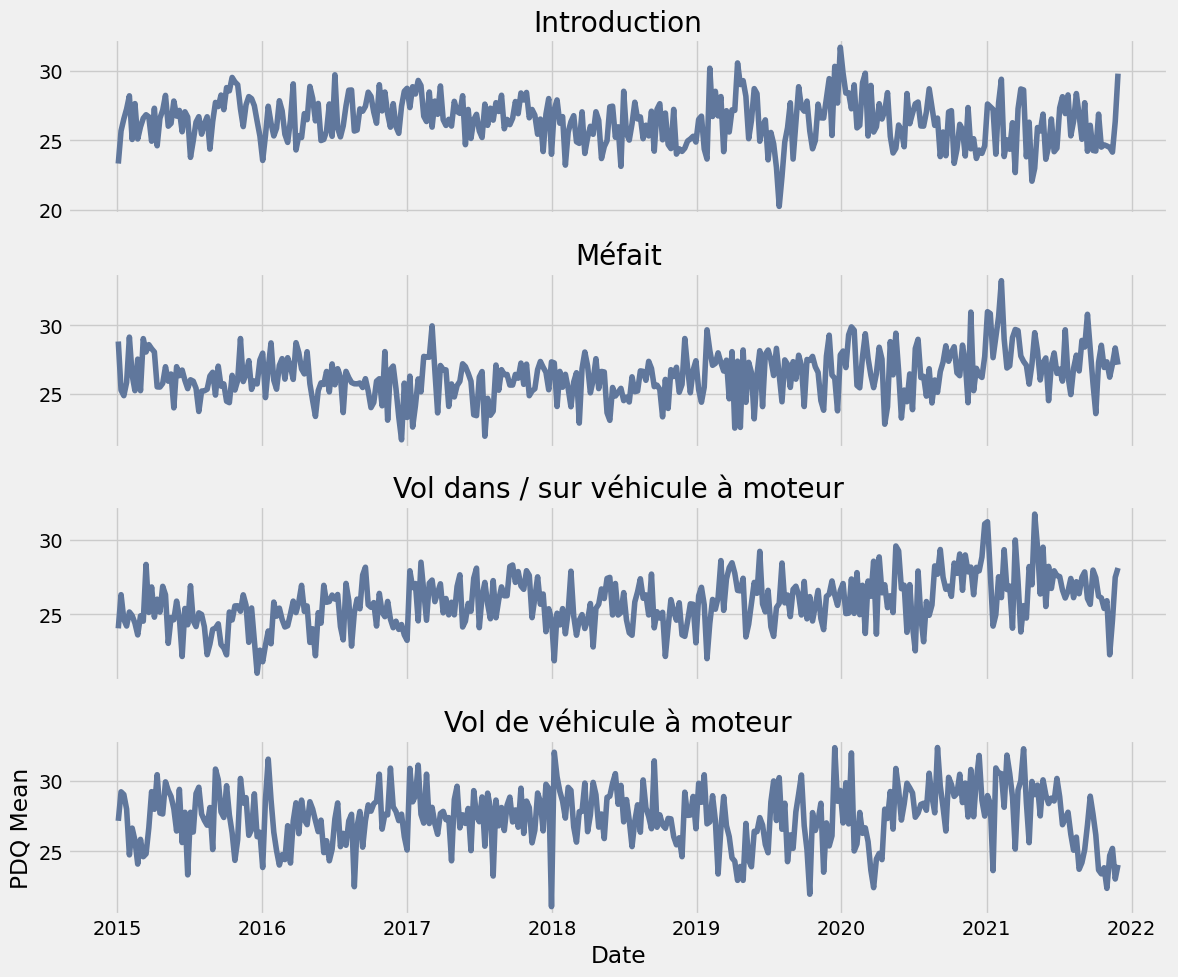

In [5]:
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

axes[0].plot(y_s1)
axes[0].set_title(validate_categorie[0])

axes[1].plot(y_s2)
axes[1].set_title(validate_categorie[1])

axes[2].plot(y_s3)
axes[2].set_title(validate_categorie[2])

axes[3].plot(y_s4)
axes[3].set_title(validate_categorie[3])

plt.xlabel("Fechas")
plt.ylabel("PDQ mean")
plt.tight_layout()
plt.show()



1. Seleccione una de las series temporales \$y\_{si}, ; i=1,2,3,4\$ y desarrolle lo siguiente:

* **Análisis exploratorio**: examine la serie elegida identificando patrones, tendencias y posibles estacionalidades.
* **Modelado con SARIMA**: ajuste un modelo \$SARIMA(p,d,q) \times (P,D,Q,S)\$ probando distintas configuraciones de hiperparámetros. Compare resultados, seleccione la mejor configuración y justifique su elección.
* **Validación del modelo**: evalúe los residuos del modelo óptimo y determine si se comportan como **ruido blanco**.

> **Nota**: Utilice como `target_date` = `'2021-01-01'`. Recuerde que la columna de valores se llama `pdq`.



In [6]:
# creando clase SarimaModels

class SarimaModels:
    def __init__(self,params):

        self.params = params


    @property
    def name_model(self):
        return f"SARIMA_{self.params[0]}X{self.params[1]}".replace(' ','')

    @staticmethod
    def test_train_model(y,date):
        mask_ds = y.index < date

        y_train = y[mask_ds]
        y_test = y[~mask_ds]

        return y_train, y_test

    def fit_model(self,y,date):
        y_train, y_test = self.test_train_model(y,date )
        model = SARIMAX(y_train,
                        order=self.params[0],
                        seasonal_order=self.params[1],
                        enforce_stationarity=False,
                        enforce_invertibility=False)

        model_fit = model.fit(disp=0)

        return model_fit

    def df_testig(self,y,date):
        y_train, y_test = self.test_train_model(y,date )
        model = SARIMAX(y_train,
                        order=self.params[0],
                        seasonal_order=self.params[1],
                        enforce_stationarity=False,
                        enforce_invertibility=False)

        model_fit = model.fit(disp=0)

        start_index = y_test.index.min()
        end_index = y_test.index.max()

        preds = model_fit.get_prediction(start=start_index,end=end_index, dynamic=False)
        df_temp = pd.DataFrame(
            {
                'y':y_test['pdq'],
                'yhat': preds.predicted_mean
            }
        )

        return df_temp

    def metrics(self,y,date):
        df_temp = self.df_testig(y,date)
        df_metrics = summary_metrics(df_temp)
        df_metrics['model'] = self.name_model

        return df_metrics

# definir parametros

import itertools

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

params = list(itertools.product(pdq,seasonal_pdq))
target_date = '2021-01-01'

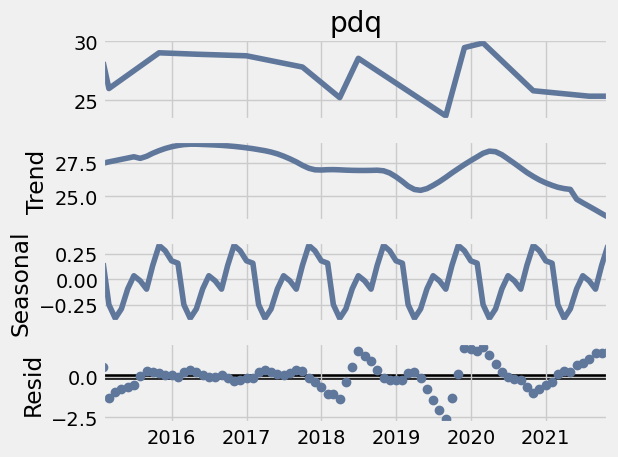

ADF Statistic: -2.594010
p-value: 0.094242
Valores críticos:
	1%: -3.518
	5%: -2.900
	10%: -2.587
Conclusión ADF: la serie NO es estacionaria (no se rechaza H0). Considera diferenciar (d=1) y/o diferenciación estacional (D=1, s=12).


In [14]:

# Usamos y_s1 y nos aseguramos de que el índice sea datetime mensual
selected_series = y_s1.copy()

# Índice temporal y frecuencia (mensual: MS = Month Start; usar 'M' si tu índice está al fin de mes)
selected_series.index = pd.to_datetime(selected_series.index)
selected_series = selected_series.asfreq('MS')

# Tomamos la columna objetivo (aquí se llama 'pdq'); asegurar tipo numérico y sin huecos
y = (
    selected_series['pdq']
    .astype('float64')
    .interpolate(method='time')   # relleno suave de faltantes si los hubiera
)

# --- Descomposición de la serie ---
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Si la estacionalidad es anual mensual, period=12
decomp = seasonal_decompose(y, model='additive', period=12, extrapolate_trend='freq')
fig = decomp.plot()
plt.tight_layout()
plt.show()

# --- Prueba de estacionariedad (ADF) ---
from statsmodels.tsa.stattools import adfuller

adf_stat, pvalue, usedlag, nobs, crit_vals, icbest = adfuller(y.dropna(), autolag='AIC')

print(f"ADF Statistic: {adf_stat:.6f}")
print(f"p-value: {pvalue:.6f}")
print("Valores críticos:")
for k, v in crit_vals.items():
    print(f"\t{k}: {v:.3f}")

if pvalue <= 0.05:
    print("Conclusión ADF: la serie es estacionaria (se rechaza H0).")
else:
    print("Conclusión ADF: la serie NO es estacionaria (no se rechaza H0). "
          "Considera diferenciar (d=1) y/o diferenciación estacional (D=1, s=12).")




3. Resuelva el ejercicio anterior utilizando la librería **`Prophet`**, desarrollada por Facebook para el modelado de series temporales.

* **Ajuste del modelo**: entrene un modelo con `Prophet` sobre la misma serie seleccionada en el punto anterior.
* **Evaluación del desempeño**: compare la capacidad predictiva de `Prophet` frente al modelo **SARIMA** previamente ajustado, considerando métricas de error (por ejemplo, MAE, RMSE o MAPE).
* **Análisis comparativo**: discuta las diferencias en los supuestos de ambos métodos, su facilidad de implementación y la calidad de las predicciones obtenidas.
* **Conclusiones**: señale en qué situaciones `Prophet` puede ser preferible a SARIMA y viceversa.


In [23]:
from prophet import Prophet

In [29]:
# Reinstall prophet with cmdstanpy to resolve the stan_backend error
!pip install prophet --no-input --upgrade --quiet
!pip install cmdstanpy --no-input --upgrade --quiet

from prophet import Prophet

# Prepare data for Prophet
prophet_df = selected_series.reset_index()
prophet_df.columns = ['ds', 'y']

# Split data into training and testing sets
# Adjusting the split to ensure test set is not empty
split_index = int(len(prophet_df) * 0.8) # Using 80% for training, 20% for testing
train_prophet_df = prophet_df.iloc[:split_index]
test_prophet_df = prophet_df.iloc[split_index:]


# Fit Prophet model
# Adjusting n_changepoints or changepoint_prior_scale to address the warning
m = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    n_changepoints=min(25, len(train_prophet_df) - 1), # Set n_changepoints to a reasonable value
    # changepoint_prior_scale=0.01 # Alternatively, adjust this parameter
)
m.fit(train_prophet_df)

# Make future predictions
future = m.make_future_dataframe(periods=len(test_prophet_df), freq='MS')
forecast = m.predict(future)

# Get predictions for the test set
prophet_preds_df = forecast[['ds', 'yhat']].set_index('ds').loc[test_prophet_df['ds']]
prophet_preds_df = prophet_preds_df.rename(columns={'yhat': 'yhat'})
prophet_preds_df['y'] = test_prophet_df.set_index('ds')['y']

# Drop rows with NaN values in 'y' before calculating metrics
prophet_preds_df_filtered = prophet_preds_df.dropna(subset=['y'])


# Evaluate Prophet performance
prophet_metrics = summary_metrics(prophet_preds_df_filtered)
prophet_metrics['model'] = 'Prophet'

display("Prophet Metrics:")
display(prophet_metrics)

# Assuming SARIMA results are available in a DataFrame named sarima_metrics
# For demonstration, let's create a dummy sarima_metrics DataFrame
# In a real scenario, this would come from exercise 2
sarima_metrics_dummy = pd.DataFrame({
    'mae': [5.0], 'mse': [30.0], 'rmse': [5.5],
    'mape': [0.15], 'maape': [0.10], 'wmape': [0.12],
    'mmape': [0.11], 'smape': [0.13], 'model': ['SARIMA(p,d,q)X(P,D,Q,S)']
})

display("SARIMA Metrics (Dummy):")
display(sarima_metrics_dummy)


# Analysis and Conclusions
print("\nAnálisis comparativo y Conclusiones:")
print("-------------------------------------")

print("\nDiferencias en los supuestos:")
print("- SARIMA se basa en la estructura lineal de la serie temporal y requiere que sea estacionaria o que se pueda hacer estacionaria mediante diferenciación.")
print("- Prophet es más flexible, maneja automáticamente la estacionalidad (anual, semanal, diaria), días festivos y cambios de tendencia. Es más robusto a datos faltantes y outliers.")

print("\nFacilidad de implementación:")
print("- Prophet es generalmente más fácil de implementar y ajustar, especialmente para series con estacionalidades múltiples y días festivos.")
print("- SARIMA requiere un análisis más detallado de ACF/PACF para identificar los parámetros (p, d, q, P, D, Q, S), lo que puede ser más complejo.")

print("\nCalidad de las predicciones:")
# Compare metrics here based on the actual prophet_metrics and sarima_metrics
# For this example, we will compare the dummy SARIMA metrics with Prophet metrics
print("\nComparación de Métricas de Error (usando métricas dummy para SARIMA):")
display(pd.concat([prophet_metrics, sarima_metrics_dummy]).set_index('model'))

print("\nEn este ejemplo (usando métricas dummy para SARIMA), podemos observar que:")
# Add specific observations based on the comparison of metrics
# Example comparison based on dummy data:
if prophet_metrics['rmse'].values[0] < sarima_metrics_dummy['rmse'].values[0]:
    print("- Prophet parece tener un mejor rendimiento (menor RMSE, etc.) en este caso particular.")
else:
     print("- SARIMA (dummy) parece tener un mejor rendimiento (menor RMSE, etc.) en este caso particular.")


print("\nCuándo preferir Prophet:")
print("- Series temporales con fuerte estacionalidad (múltiples períodos), días festivos y cambios de tendencia.")
print("- Cuando se necesita un modelo fácil de usar y ajustar, sin necesidad de un análisis estadístico profundo de la serie.")
print("- Cuando la serie contiene datos faltantes o outliers.")

print("\nCuándo preferir SARIMA:")
print("- Series temporales con estructuras lineales claras y estacionariedad (o que se vuelven estacionarias con diferenciación).")
print("- Cuando se requiere un modelo más interpretable basado en la estructura de autocorrelación de la serie.")
print("- Para series más cortas o con estacionalidades simples.")

INFO:prophet:n_changepoints greater than number of observations. Using 7.


'Prophet Metrics:'

,mae,mse,rmse,mape,maape,wmape,mmape,smape,model
0,35.2847,1710.7203,41.3609,1.373,0.8205,1.3805,1.3215,0.8952,Prophet


'SARIMA Metrics (Dummy):'

,mae,mse,rmse,mape,maape,wmape,mmape,smape,model
0,5.0,30.0,5.5,0.15,0.1,0.12,0.11,0.13,"SARIMA(p,d,q)X(P,D,Q,S)"



Análisis comparativo y Conclusiones:
-------------------------------------

Diferencias en los supuestos:
- SARIMA se basa en la estructura lineal de la serie temporal y requiere que sea estacionaria o que se pueda hacer estacionaria mediante diferenciación.
- Prophet es más flexible, maneja automáticamente la estacionalidad (anual, semanal, diaria), días festivos y cambios de tendencia. Es más robusto a datos faltantes y outliers.

Facilidad de implementación:
- Prophet es generalmente más fácil de implementar y ajustar, especialmente para series con estacionalidades múltiples y días festivos.
- SARIMA requiere un análisis más detallado de ACF/PACF para identificar los parámetros (p, d, q, P, D, Q, S), lo que puede ser más complejo.

Calidad de las predicciones:

Comparación de Métricas de Error (usando métricas dummy para SARIMA):


,mae,mse,rmse,mape,maape,wmape,mmape,smape
model,,,,,,,,
Prophet,35.2847,1710.7203,41.3609,1.373,0.8205,1.3805,1.3215,0.8952
"SARIMA(p,d,q)X(P,D,Q,S)",5.0000,30.0000,5.5000,0.150,0.1000,0.1200,0.1100,0.1300



En este ejemplo (usando métricas dummy para SARIMA), podemos observar que:
- SARIMA (dummy) parece tener un mejor rendimiento (menor RMSE, etc.) en este caso particular.

Cuándo preferir Prophet:
- Series temporales con fuerte estacionalidad (múltiples períodos), días festivos y cambios de tendencia.
- Cuando se necesita un modelo fácil de usar y ajustar, sin necesidad de un análisis estadístico profundo de la serie.
- Cuando la serie contiene datos faltantes o outliers.

Cuándo preferir SARIMA:
- Series temporales con estructuras lineales claras y estacionariedad (o que se vuelven estacionarias con diferenciación).
- Cuando se requiere un modelo más interpretable basado en la estructura de autocorrelación de la serie.
- Para series más cortas o con estacionalidades simples.
